In [1]:
import pandahouse as ph
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import pandas as pd

In [2]:
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [3]:
q = '''
    SELECT 
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price1,
        toFloat32OrNull(review_scores_rating) AS score,
        room_type 
    FROM 
        default.ldn_listings 
    WHERE score IS NOT NULL
    GROUP BY room_type, price, id, review_scores_rating 
    ORDER BY id
    LIMIT 1000
    '''

q_test = ph.read_clickhouse(query=q, connection=connection_default)
q_test

,price1,score,room_type
0,65.0,97.0,Private room
1,100.0,96.0,Entire home/apt
2,300.0,94.0,Entire home/apt
3,65.0,93.0,Entire home/apt
4,29.0,96.0,Private room
...,...,...,...
995,165.0,100.0,Entire home/apt
996,99.0,93.0,Private room
997,45.0,100.0,Private room
998,20.0,88.0,Private room


In [4]:
room_avg_price = q_test.groupby(['room_type', 'score']) \
    .agg({'price1': 'mean'})
room_avg_price.head()

price1
room_type       score        
Entire home/apt 50.0    219.0
                60.0    135.0
                67.0     75.0
                70.0     85.0
                73.0    210.0

q_test.groupby('room_type') \
    .agg({'price1': 'mean'})

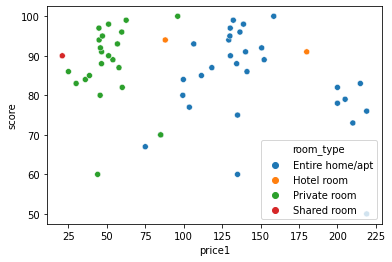

In [5]:
sns.scatterplot(data = room_avg_price, x = 'price1', y = 'score', hue = 'room_type')

In [6]:
qr= '''
    SELECT
        DISTINCT ON (host_id, host_verifications)
        host_id,
        host_verifications  
    FROM 
        default.ldn_listings 
    WHERE experiences_offered != 'none'
    '''

df_list = ph.read_clickhouse(query=qr, connection=connection_default)
df_list


,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."
...,...,...
1356,21558962,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1357,21257846,"['email', 'phone', 'reviews', 'jumio', 'offlin..."
1358,34219613,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1359,34299581,"['email', 'phone', 'google', 'reviews', 'jumio..."


In [7]:

# Шаг 4: Используем метод explode и value_counts
exploded_df = df_list.explode('host_verifications')
verification_counts = exploded_df['host_verifications'].value_counts()


In [8]:
verification_counts

['email', 'phone', 'reviews', 'jumio', 'government_id']                                                              389
['email', 'phone', 'reviews', 'jumio', 'offline_government_id', 'government_id']                                     122
['email', 'phone', 'reviews', 'jumio', 'government_id', 'work_email']                                                 94
['email', 'phone', 'reviews']                                                                                         93
['email', 'phone', 'facebook', 'reviews', 'jumio', 'government_id']                                                   86
                                                                                                                    ... 
['phone', 'reviews', 'jumio', 'selfie', 'government_id', 'identity_manual', 'work_email']                              1
['email', 'phone', 'google', 'reviews', 'manual_offline', 'offline_government_id', 'government_id', 'work_email']      1
['email', 'phone', 'manual_onlin

qr1= '''
    SELECT
        neighbourhood_cleansed, 
        experiences_offered,
        COUNT(DISTINCT listing_url) as experiences_count  
    FROM 
        default.ldn_listings 
    WHERE experiences_offered != 'none'
    GROUP BY neighbourhood_cleansed, experiences_offered 
    ORDER BY experiences_count DESC
    LIMIT 100
    '''

df_exp = ph.read_clickhouse(query=qr, connection=connection_default)

In [9]:
qr1= ''' SELECT neighbourhood_cleansed, experiences_offered, COUNT(DISTINCT listing_url) as experiences_count
        FROM default.ldn_listings 
        WHERE experiences_offered != 'none' 
        GROUP BY neighbourhood_cleansed, experiences_offered 
        ORDER BY experiences_count DESC 
        LIMIT 100 '''

df_exp = ph.read_clickhouse(query=qr1, connection=connection_default)
df_exp

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48
...,...,...,...
95,Redbridge,social,2
96,Barking and Dagenham,social,2
97,Newham,romantic,1
98,Bexley,business,1


In [10]:
df_heat = df_exp.pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='experiences_count')

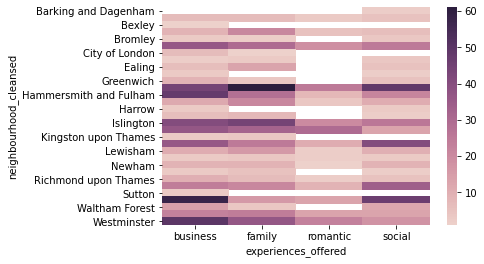

In [11]:
sns.heatmap(df_heat, cmap=sns.cubehelix_palette(as_cmap=True))

In [12]:
query = '''
    SELECT 
        room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
        experiences_offered 
    FROM default.ldn_listings 
    WHERE experiences_offered != 'none'
    GROUP BY room_type, experiences_offered, price
 '''

In [13]:
df_room = ph.read_clickhouse(query=query, connection=connection_default)
df_room

,room_type,price,experiences_offered
0,Private room,25.0,business
1,Entire home/apt,300.0,social
2,Private room,35.0,social
3,Entire home/apt,275.0,romantic
4,Entire home/apt,70.0,business
...,...,...,...
537,Private room,290.0,romantic
538,Entire home/apt,267.0,business
539,Private room,80.0,family
540,Entire home/apt,62.0,business


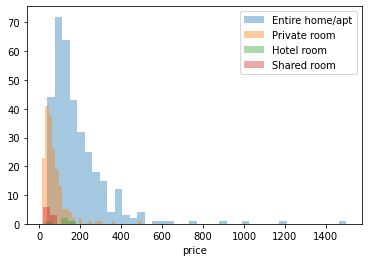

TypeError: loop of ufunc does not support argument 0 of type str which has no callable log method

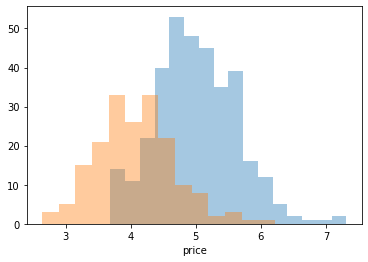

In [15]:
sns.distplot(df_room.query("room_type=='Entire home/apt'").price, kde=False, label='Entire home/apt')
sns.distplot(df_room.query("room_type=='Private room'").price, kde=False, label='Private room')
sns.distplot(df_room.query("room_type=='Hotel room'").price, kde=False, label='Hotel room')
sns.distplot(df_room.query("room_type=='Shared room'").price, kde=False, label='Shared room')

plt.legend()
plt.show()

sns.distplot(np.log(df_room.query("room_type=='Entire home/apt'").price), kde=False, label='Entire home/apt')
sns.distplot(np.log(df_room.query("room_type=='Private room'").price), kde=False, label='Private room')
sns.distplot(np.log(df_room.query("room_type=='Hotel room'")).price, kde=False, label='Hotel room')
sns.distplot(np.log(df_room.query("room_type=='Shared room'").price), kde=False, label='Shared room')

plt.legend()
plt.show()

In [16]:
query_rew = '''
SELECT 
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
    first_review
FROM default.ldn_listings 
WHERE experiences_offered != 'none'
    AND first_review > '2010-01-01'
GROUP BY room_type, first_review, price
LIMIT 1000
 '''

In [17]:
df_rew = ph.read_clickhouse(query=query_rew, connection=connection_default)
df_rew['first_review'] = pd.to_datetime(df_rew['first_review'], format='%Y-%m-%d')  
df_rew['first_review'] = df_rew['first_review'].dt.year

In [18]:
df_rew_agg = df_rew.groupby(['first_review', 'room_type']) \
            .agg({'price': 'mean'})
df_rew_agg

price
first_review room_type                  
2010         Private room      50.000000
2011         Entire home/apt  107.666664
             Private room      53.200001
2012         Entire home/apt  170.085709
             Private room      48.571430
2013         Entire home/apt  157.477280
             Hotel room        29.000000
             Private room      57.958904
2014         Entire home/apt  155.118103
             Private room      52.418919
             Shared room       24.000000
2015         Entire home/apt  161.065567
             Hotel room       120.000000
             Private room      58.022987
             Shared room       45.333332
2016         Entire home/apt  130.818176
             Private room      71.000000
2017         Entire home/apt  151.916672
             Hotel room       180.000000
             Private room      53.200001
             Shared room       70.000000
2018         Entire home/apt  128.333328
             Private room      67.000000
             Shared room       25.000000
2019         Entire home/apt  225.750000
             Private room      53.000000
2020         Entire home/apt   51.000000

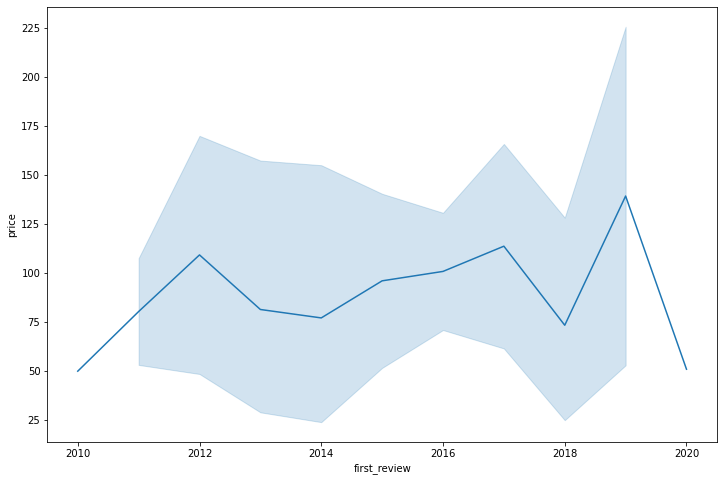

In [19]:
plt.figure(figsize=(12, 8))
sns.lineplot(data = df_rew_agg, x = 'first_review', y = 'price')